In [77]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
#Load data: Load both the merged data and the original unaltered data 
merged_file = '../DataSet/merged_data2.csv'
data = pd.read_csv(merged_file, parse_dates =[2])

#market_file = '../DataSet/market_clean.csv'
#data = pd.read_csv(market_file, parse_dates =[1])

#news_file = '../DataSet/news_train_df.csv'
#news_data = pd.read_csv(news_file, parse_dates =[1])

In [3]:
#Combine mean of news data information by day
data = data.dropna(axis = 0, how = 'any').groupby('assetName').resample('d', on = 'time').mean().dropna(axis = 0, how = 'any')
data = data.reset_index(drop = False)

In [4]:
data.columns

Index(['assetName', 'time', 'Unnamed: 0', 'Unnamed: 0.1', 'volume', 'close',
       'open', 'returnsClosePrevRaw1', 'returnsOpenPrevRaw1',
       'returnsClosePrevMktres1', 'returnsOpenPrevMktres1',
       'returnsClosePrevRaw10', 'returnsOpenPrevRaw10',
       'returnsClosePrevMktres10', 'returnsOpenPrevMktres10',
       'returnsOpenNextMktres10', 'universe', 'urgency', 'takeSequence',
       'bodySize', 'companyCount', 'marketCommentary', 'sentenceCount',
       'wordCount', 'firstMentionSentence', 'relevance', 'sentimentClass',
       'sentimentNegative', 'sentimentNeutral', 'sentimentPositive',
       'sentimentWordCount', 'noveltyCount12H', 'noveltyCount24H',
       'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D', 'volumeCounts12H',
       'volumeCounts24H', 'volumeCounts3D', 'volumeCounts5D',
       'volumeCounts7D'],
      dtype='object')

In [5]:
#Choose features to use in model
features = ['volume', 'close', 'open', 'returnsClosePrevRaw1',
       'returnsOpenPrevRaw1', 'returnsClosePrevMktres1',
       'returnsOpenPrevMktres1', 'returnsClosePrevRaw10',
       'returnsOpenPrevRaw10', 'returnsClosePrevMktres10',
       'returnsOpenPrevMktres10',
        'sentenceCount', 'wordCount', 'sentimentClass', 'sentimentNegative', 'sentimentNeutral',
       'sentimentPositive', 'sentimentWordCount', 'noveltyCount12H',
       'noveltyCount24H', 'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D',
       'volumeCounts12H', 'volumeCounts24H', 'volumeCounts3D',
       'volumeCounts5D', 'volumeCounts7D' ]

In [20]:
#Set up X and y for modeling
X = data[features]
y = (data.returnsOpenNextMktres10 >= 0).values
y = y.astype(int)

#Set up additional parameters to calculate final metric used in Two Sigma competition
universe = data.universe
r = data.returnsOpenNextMktres10
day = data.time.dt.date

In [21]:
#Create train and test sets
X_train, X_test, y_train, y_test, _, univ_test, _, r_test, _, day_test = \
       train_test_split(X, y, universe, r, day, test_size = 0.3, random_state = 42)

In [22]:
print(len(y_train))
print(len(y_test))

379311
162562


In [31]:
#Set up model and determine best parameters for XGBClassifier.  After tuning parameters comment out 
#remaining lines of code
#gb = XGBClassifier()
#params = {'n_estimators': [200, 500, 1000, 2000, 4000],
#          'max_depth': [4, 6, 8, 10],
#          'learning_rate': [.001, .01, 0.1, 0.3],
#          'booster': ['gbtree', 'gblinear', 'dart']}

#gb_cv = GridSearchCV(gb, params, cv = 5, n_jobs = -1)

#Preform grid search to find best fit parameters using XGBClassifier
#gb_cv.fit(X_train, y_train)

#Show the best parameters and best score value determined from the grid search
#print(gb_cv.best_params_)
#print(gb_cv.best_score_)

In [32]:
#Initialize model with optimized parameters
params = {'booster': 'gbtree',
          'learning_rate': 0.1,
          'max_depth': 6,
           'n_estimators': 100,
          'n_jobs': 4}
model = XGBClassifier(**params)

In [33]:
%%time
#Fit model to training data
model.fit(X_train, y_train)

Wall time: 41 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [34]:
#Collection prediction values for classification
y_pred = model.predict_proba(X_test)
predictions = [round(value[1]) for value in y_pred]
print(y_pred[20:30])

[[0.52993214 0.47006786]
 [0.47777438 0.5222256 ]
 [0.5232013  0.4767987 ]
 [0.5175458  0.4824542 ]
 [0.44618    0.55382   ]
 [0.5712421  0.42875794]
 [0.4763385  0.5236615 ]
 [0.5267178  0.47328225]
 [0.5548254  0.44517457]
 [0.4546051  0.5453949 ]]


In [40]:
#Calculate accuracy score for the predictions
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %.4f'%(accuracy))

Accuracy: 0.5499


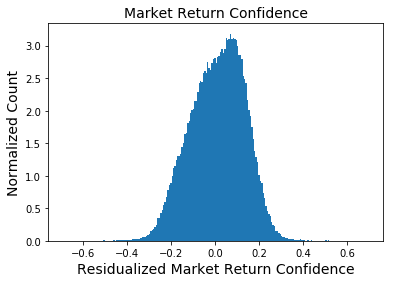

In [84]:
#Plot histogram of prediction results.  Notice, using the Two Sigma scoring metric to calculate the 
#conifidence that returnOpenNextMktres10 is negative or positive.
y_r = y_pred[:,1]*2 - 1
plt.hist(y_r, bins = 'auto', density = True)
plt.xlabel('Residualized Market Return Confidence', fontsize = 14)
plt.ylabel('Normalized Count', fontsize = 14)
plt.title('Market Return Confidence', fontsize = 14)
plt.savefig('ReturnConfidence.png', bbox = 'tight')
plt.show()

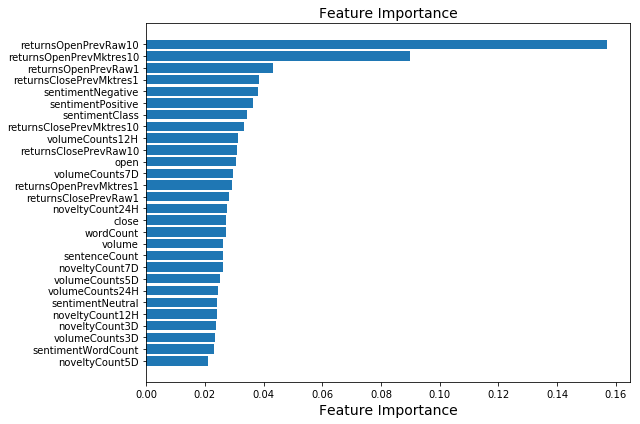

In [66]:
#Display bar graph of feature importance in model
feat_imp = model.feature_importances_
feat = pd.DataFrame()
feat['feature'] = features
feat['importance'] = feat_imp
feat = feat.sort_values('importance')

wide = np.arange(len(feat_imp))
plt.figure(figsize = (9,6))
plt.barh(wide, feat['importance'])
plt.yticks(wide, feat['feature'])
plt.xlabel('Feature Importance', fontsize = 14)
plt.title('Feature Importance', fontsize = 14)
plt.tight_layout()
plt.savefig('FeatureImportance.png', bbox = 'tight')
plt.show()

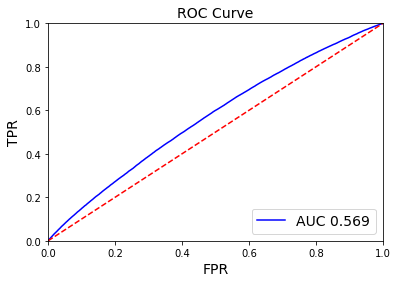

In [88]:
#Plot ROC curve for XGBClassifier model
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
auc = roc_auc_score(y_test, y_pred[:,1])

plt.plot(fpr, tpr, color = 'blue')
plt.plot([0,1], [0,1], color = 'red', linestyle = '--')
plt.xlabel('FPR', fontsize = 14)
plt.ylabel('TPR', fontsize = 14)
plt.title('ROC Curve', fontsize = 14)
plt.axis([0, 1, 0, 1])
plt.legend(['AUC %.3f'%auc], loc = 'lower right', fontsize = 14)
plt.savefig('ROC_XGBClassifier.png', bbox = 'tight')
plt.show()

In [83]:
#Calculate the metric used Two Sigma competition for scoring

#Clip outliers for the returnsOpenNextMktres10 data
r_test2 = r_test.clip(-1,1)

#Calculate scoring metric
y_int = y_r*univ_test*r_test2
df = pd.DataFrame()

df['day'] = day_test
df['y_int'] = y_int

y_i = df.groupby('day').sum().values.flatten()
mean_i = np.mean(y_i)
std_i = np.std(y_i)

score_gb = mean_i/std_i
print('Score using XGBClassifier %.4f'%(score_gb))


Score using XGBClassifier 0.4831
